# AI-Clinical-Rehab-Platform

- 採用模型V3.1

- 特徵工程 (Feature Engineering)
1. 建立合力向量 (Magnitude)。<br>
    物理公式：$Mag = \sqrt{x^2 + y^2 + z^2}$
2. 導入統計特徵 (Statistical Features)：<br>
    目前的模型只看「這一點」的數值。要讓 AI 學會看「這一小段時間」的趨勢，
    * 平均值 (Mean) 與標準差 (Std)：告訴 AI 訊號的波動程度。
    * 訊號幅值面積 (SMA)：辨識能量消耗的關鍵指標。
3. 訓練 V3.1 特徵強化版模型：<br>
     10 個人的資料，從原本的 3 個欄位擴充到 4 個（加上 Magnitude）甚至更多，重新跑一遍訓練，看看昨天的「混淆矩陣」中，那幾個重災區（如 Stand vs. Arms）的 F1-score 是否能顯著提升。

## Basic setting

In [ ]:
import pandas as pd
import numpy as np
import schema
from scipy.stats import ks_2samp
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models

### 讀取特徵工程過的受試者資料

In [ ]:
# 直接取得最終矩陣，變數名稱與你原本的後續 code (v3.1) 完全一致
X_final, y_final = schema.get_final_training_data('data_raw')
print("特徵強化後的矩陣形狀：", X_final.shape) 
# 預期輸出：(總視窗數, 128, 4)

✅ 受試者 1 處理完成，視窗數量: 548
✅ 受試者 2 處理完成，視窗數量: 554
✅ 受試者 3 處理完成，視窗數量: 551
✅ 受試者 4 處理完成，視窗數量: 550
✅ 受試者 5 處理完成，視窗數量: 529
✅ 受試者 6 處理完成，視窗數量: 502
✅ 受試者 7 處理完成，視窗數量: 534
✅ 受試者 8 處理完成，視窗數量: 519
✅ 受試者 9 處理完成，視窗數量: 535
✅ 受試者 10 處理完成，視窗數量: 525
特徵強化後的矩陣形狀： (5347, 128, 4)


### 調整模型

In [3]:
brain_v3_1 = models.Sequential([
    layers.Conv1D(filters = 32, kernel_size = 3, activation='relu', input_shape = (128, 4)),
    layers.MaxPooling1D(pool_size = 2),
    
    layers.Flatten(),

    layers.Dense(64, activation = 'relu'), 
    layers.Dropout(0.2), # 強化紀律
    layers.Dense(13, activation='softmax') 
])

brain_v3_1.summary()

c:\Users\freea\Desktop\side_project\AI-Clinical-Rehab-Platform\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 32)        │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2016)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       129,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,349 (509.18 KB)

 Trainable params: 130,349 (509.18 KB)

 Non-trainable params: 0 (0.00 B)

### 訓練與視覺化診斷

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
X_final, y_final, test_size = 0.2, random_state = 42, stratify=y_final
)

print("訓練集資料筆數：", len(X_train))
print("驗證集資料筆數：", len(X_val))

brain_v3_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("開始進行跨受試者大數據訓練...")
history_v3_1_multi = brain_v3_1.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 32,
    validation_data=(X_val, y_val),
    verbose=1
)

訓練集資料筆數： 4277
驗證集資料筆數： 1070
開始進行跨受試者大數據訓練...
Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4664 - loss: 1.5363 - val_accuracy: 0.6523 - val_loss: 0.9791
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6306 - loss: 0.9824 - val_accuracy: 0.7271 - val_loss: 0.7637
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7066 - loss: 0.7817 - val_accuracy: 0.8093 - val_loss: 0.5949
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7676 - loss: 0.6273 - val_accuracy: 0.8402 - val_loss: 0.4649
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7971 - loss: 0.5385 - val_accuracy: 0.8654 - val_loss: 0.4323
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8057 - loss: 0.5026 - val_accuracy: 0.8626 - val_loss: 0.3947
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8324 - loss: 0.4498 - val_accuracy: 0.8607 - val_loss: 0.3930
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accur

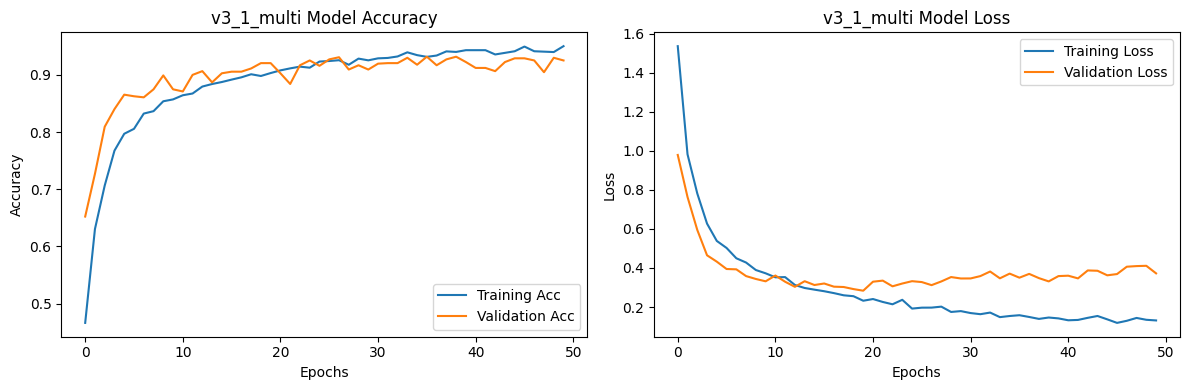

In [5]:
# 3. 繪製訓練結果圖表
plt.figure(figsize=(12, 4))

# 準確率圖 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history_v3_1_multi.history['accuracy'], label='Training Acc')
plt.plot(history_v3_1_multi.history['val_accuracy'], label='Validation Acc')
plt.title('v3_1_multi Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 損失圖 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_v3_1_multi.history['loss'], label='Training Loss')
plt.plot(history_v3_1_multi.history['val_loss'], label='Validation Loss')
plt.title('v3_1_multi Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
混淆矩陣圖表已儲存為 confusion_matrix_v3_multi.png


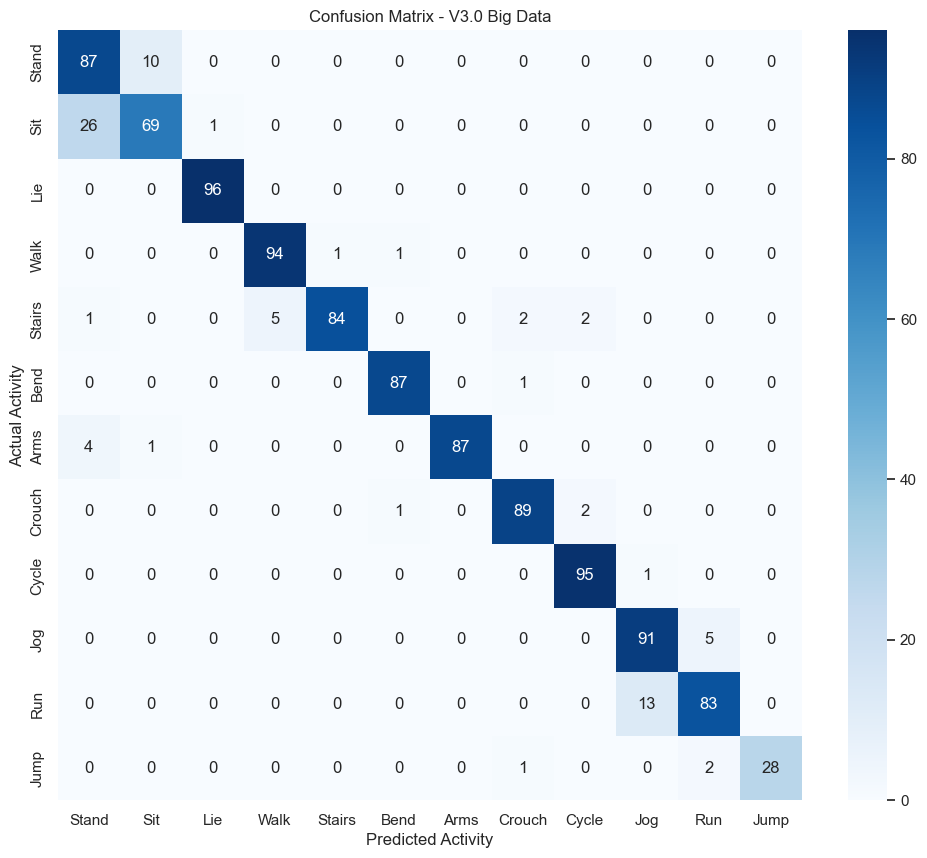

In [6]:
# 1.　取得模型的預測結果，這裡會對驗證集 X_val 進行預測，並用 argmax 找出機率最高的標籤
y_pred_probs = brain_v3_1.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis = 1)

# 2. 計算混淆矩陣，指定標籤範圍為 1 到 12，對應 MHEALTH 的 12 種有效動作
cm = confusion_matrix(y_val, y_pred, labels=range(1, 13))

#3. 定義動作名稱清單（供圖表標籤使用）
action_names = [
'Stand', 'Sit', 'Lie', 'Walk', 'Stairs',
'Bend', 'Arms', 'Crouch', 'Cycle',
'Jog', 'Run', 'Jump'

]
# 4. 繪製熱圖 (Heatmap)，注意：為了符合規範，不使用 .figure()，直接使用 sns 繪圖並儲存
sns.set(rc = {'figure.figsize':(12, 10)})
sns.heatmap(cm, annot = True, fmt='d', cmap=  'Blues',
xticklabels=action_names, yticklabels = action_names)
plt.title('Confusion Matrix - V3.0 Big Data')
plt.ylabel('Actual Activity')
plt.xlabel('Predicted Activity')

# 5. 儲存結果圖檔
plt.savefig('confusion_matrix_v3_1_multi.png')
print("混淆矩陣圖表已儲存為 confusion_matrix_v3_multi.png")